In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from sklearn.model_selection import train_test_split
import glob
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Path to the data folder
data_path = "Mod7_data/data"
file_pattern = os.path.join(data_path, "fof_subhalo_tab_000.*.hdf5") 
files = sorted(glob.glob(file_pattern))

# Loop through all files
# for file in files:
#     with h5py.File(file, 'r') as f:
#         print(f"File: {file}")

In [3]:
with h5py.File(files[0], 'r') as f: #files[0] = Mod7_data/data/fof_subhalo_tab_000.0.hdf5 (1st data file)
    data = f['Subhalo'].keys() 
    group = f['Group'].keys()
    print(data)
    print(group)

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad', 'SubhaloStarMetallicityM

In [14]:
# for file in files:
#     with h5py.File(file, 'r') as f:
#         pos = f['Subhalo']['SubhaloPos'][:]  # shape: (N, 3)

# # 2D projection
# # if pos.shape[0] > 10000:
# #     idx = np.random.choice(pos.shape[0], 10000, replace=False)
# #     pos = pos[idx]

# # Plot 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=1, alpha=0.3)

# ax.set_xlabel('X [ckpc/h]')
# ax.set_ylabel('Y [ckpc/h]')
# ax.set_zlabel('Z [ckpc/h]')
# ax.set_title('3D Distribution of Subhalos (Snapshot 0, TNG50-1)')
# plt.tight_layout()
# plt.show()


In [8]:
# with h5py.File(files[0], 'r') as f:
#     subhalo_pos = f["Subhalo"]["SubhaloPos"][:]      # (N, 3)
#     subhalo_grnr = f["Subhalo"]["SubhaloGrNr"][:]    # (N,)
#     group_mass = f["Group"]["GroupMass"][:] * 1e10    # Msun/h

# # Choose a specific FoF group (e.g. group 0)
# group_id = 3
# mask = subhalo_grnr == group_id
# group_subhalo_pos = subhalo_pos[mask]

# # Optional: convert to Mpc/h
# group_subhalo_pos /= 1000.0

# # Plot 3D
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# # ax.scatter(group_subhalo_pos[:, 0], group_subhalo_pos[:, 1], group_subhalo_pos[:, 2], s=20)

# ax.set_title(f"Subhalos in FoF Group {group_id}\nTotal Mass: {group_mass[group_id]:.2e} Msun/h")
# ax.set_xlabel("X [Mpc/h]")
# ax.set_ylabel("Y [Mpc/h]")
# ax.set_zlabel("Z [Mpc/h]")
# # plt.show()

### Loading Subhalo and Group fields from our data files to be used later

In [237]:
fields = [
    'SubhaloMassType',              # [N, 6] → use stellar mass (index 4)
    'SubhaloVmax',                  # [N]
    'SubhaloHalfmassRadType',      # [N, 6] → use stellar (index 4)
    'SubhaloPos',                  # [N, 3] → for edge creation
    'SubhaloGrNr',                 # [N] → FoF group
    'SubhaloStellarPhotometrics',
    'SubhaloVel'
]

halo_fields = ['GroupFirstSub', 'Group_M_Crit200']  # you can add more like GroupMass, GroupPos, etc.

In [238]:
all_data = {field: [] for field in fields}

for file in files:
    with h5py.File(file, 'r') as f:
        for field in fields:
            all_data[field].append(f['Subhalo'][field][:])

# Concatenate
for field in fields:
    all_data[field] = np.concatenate(all_data[field], axis=0)

all_data_halo = {field: [] for field in halo_fields}

for file in files:
    with h5py.File(file, 'r') as f:
        for field in halo_fields:
            all_data_halo[field].append(f['Group'][field][:])

# Concatenate across all files
for field in halo_fields:
    all_data_halo[field] = np.concatenate(all_data_halo[field], axis=0)

In [239]:
all_data['SubhaloMassType']

array([[2.9402976e-03, 1.7919537e-02, 0.0000000e+00, 0.0000000e+00,
        3.6461995e-05, 0.0000000e+00],
       [8.3067629e-04, 1.0204608e-02, 0.0000000e+00, 0.0000000e+00,
        3.9184753e-05, 0.0000000e+00],
       [3.2379440e-04, 5.9321970e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.0277090e-04, 1.4753650e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.8255843e-04, 1.5061018e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9777255e-04, 1.4446282e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [242]:
subhalo_grnr = all_data['SubhaloGrNr']        # shape (N,)
group_firstsub = all_data_halo['GroupFirstSub']  # shape (N_groups,)
group_mass = all_data_halo['Group_M_Crit200']  # shape: (N_groups,)

# Get subhalo indices (0...N-1)
subhalo_indices = np.arange(len(subhalo_grnr))

# Lookup the central subhalo ID for each subhalo's FoF group
central_ids = group_firstsub[subhalo_grnr]

# Compare: is this subhalo the central?
is_central = (subhalo_indices == central_ids).astype(int)  # 1 = central, 0 = satellite


In [243]:
# Convert to physical units [Msun]
group_mass_phys = group_mass / h * 1e10  # FoF halo mass in Msun

# Get the halo mass for each subhalo
subhalo_halo_mass = group_mass_phys[subhalo_grnr]
log_halo_mass = np.log10(subhalo_halo_mass + 1e-8)

## Define feature matrix: 
### Selected type 4 for considering only galaxies 

    1. Stellar mass of galaxy  
    2. Its half mass radius - Comoving radius containing half of the mass of this Subhalo
    3. Maximum value of the spherically-averaged rotation curve.
    4. Whether object is central or a satellite galaxy

In [245]:
h = 0.6774

# Stellar mass from SubhaloMassType[:,4]
stellar_mass = all_data['SubhaloMassType'][:, 4] / h
log_stellar_mass = np.log10(stellar_mass + 1e-8) + 10

# Stellar halfmass radius
half_mass_rad = all_data['SubhaloHalfmassRadType'][:, 4]
log_half_mass_rad = np.log10(half_mass_rad + 1e-8)

# Vmax
vmax = all_data['SubhaloVmax']
log_vmax = np.log10(vmax + 1e-8)

photometry = all_data['SubhaloStellarPhotometrics']  # shape: (N, 8)
velocity = all_data['SubhaloVel']                    # shape: (N, 3)

# Cut: stellar mass > 1e5 and halfmass radius > 0 and Vmax > 0
mask = (log_stellar_mass > 5) & (vmax > 0) & (half_mass_rad > 0)

# Apply mask
positions = all_data['SubhaloPos'][mask]
features = np.stack([
    log_stellar_mass[mask],
    log_vmax[mask],
    log_half_mass_rad[mask]
], axis=1)  # shape: (N, 3)
is_central_masked = is_central[mask].reshape(-1, 1)  # shape: (N, 1)
features = np.hstack([features, is_central_masked])

print(f"Number of nodes after cut: {positions.shape[0]}")

Number of nodes after cut: 210


### Selecting nearest neighbors of galaxies from sklearn to establish edges

In [246]:
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data

k = 10
knn = NearestNeighbors(n_neighbors=k+1).fit(positions)
_, indices = knn.kneighbors(positions)

src = np.repeat(np.arange(len(indices)), k)
dst = indices[:, 1:].flatten()
edge_index = torch.tensor([src, dst], dtype=torch.long)

In [247]:
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(log_halo_mass[mask], dtype=torch.float)
#y = torch.tensor(log_stellar_mass[mask], dtype=torch.float)  # or any target

data = Data(x=x, edge_index=edge_index, y=y)

In [248]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class SimpleGNN(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 32)
        self.out = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.out(x).squeeze()
        return x

In [220]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.gat1 = GATConv(in_channels, 32, heads=4, concat=True)  # 4 heads → output dim = 32*4 = 128
        self.gat2 = GATConv(128, 64, heads=1, concat=True)
        self.out = torch.nn.Linear(64, 1)  # regression: 1 output

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.gat2(x, edge_index))
        x = self.out(x).squeeze()
        return x

In [265]:
model = SimpleGNN(in_channels=x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Split into train/test
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
split = int(0.8 * num_nodes)
train_mask = perm[:split]
test_mask = perm[split:]

for epoch in range(2500):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x, data.edge_index)
    loss = loss_fn(pred[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        test_loss = loss_fn(pred[test_mask], data.y[test_mask]).item()
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 0, Train Loss: 59.6468, Test Loss: 60.1902
Epoch 500, Train Loss: 4.6502, Test Loss: 0.9915
Epoch 1000, Train Loss: 4.4721, Test Loss: 0.5065
Epoch 1500, Train Loss: 4.4466, Test Loss: 0.4706
Epoch 2000, Train Loss: 4.4179, Test Loss: 0.4728


In [266]:
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)

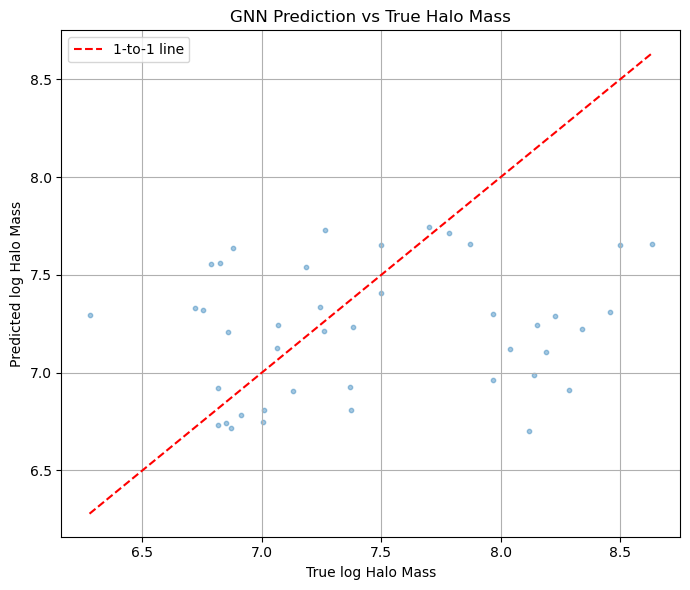

In [267]:
import matplotlib.pyplot as plt

true = data.y[test_mask].cpu().numpy()
pred = predictions[test_mask].cpu().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(true, pred, alpha=0.4, s=10)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='1-to-1 line')
plt.xlabel("True log Halo Mass")
plt.ylabel("Predicted log Halo Mass")
plt.title("GNN Prediction vs True Halo Mass")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [268]:
from sklearn.metrics import r2_score, root_mean_squared_error

r2 = r2_score(true, pred)
rmse = root_mean_squared_error(true, pred)
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f} dex")

R² score: -0.2544
RMSE: 0.6802 dex


### Define edges: So we need to know the location of all nodes (subhalos) and will use k-nearest neighbours to connect them